# BEE 4750 Homework 4: Generating Capacity Expansion

**Name**: Anthony Nicolaides

**ID**: ajn68

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE4750/hw/hw04-anthonynic28`


In [2]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 100 Points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

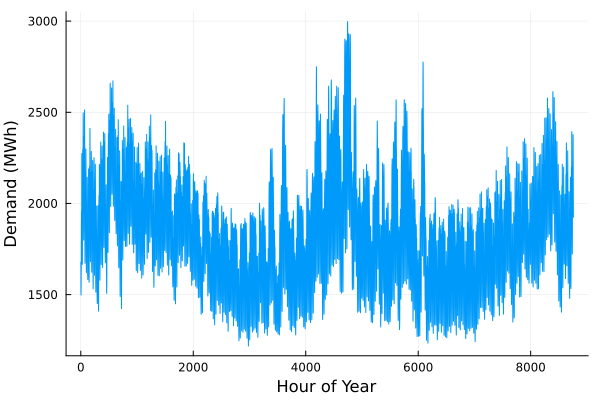

In [3]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data. This data includes fixed costs (\$/MW
installed), variable costs (\$/MWh generated), and CO<sub>2</sub>
emissions intensity (tCO<sub>2</sub>/MWh generated).

In [4]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

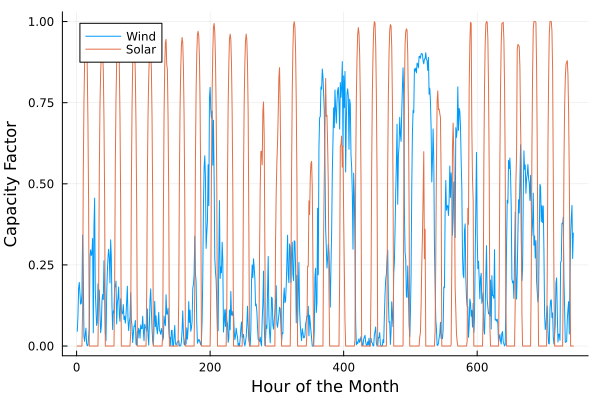

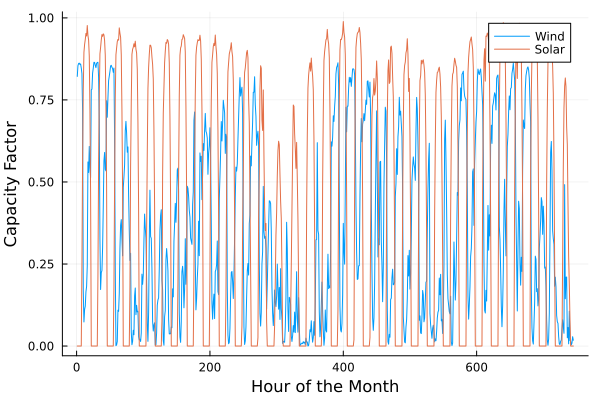

In [5]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley, NY, which currently has no existing electrical
generation infrastructure. The utility can build any of the following
plant types: geothermal, coal, natural gas combined cycle gas turbine
(CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$1000/MWh.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision!

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

### Problem 1 (22 points)

Your first task is to find a capacity expansion plan which minimizes
total costs of investment and operation.

#### Problem 1.1 (2 points)

Identify and define the decision variables for the problem. Make sure to
include units.

Variable | Meaning | Units
----------:|:-------:|:-----
x | installed capacity of each generator | MWh
y | production capacity of each generator | MWh
NSE | non-served energy | MWh

#### Problem 1.2 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s) and define any
additional required notation beyond that introduced in Problem 1.1.

Need to find generated capacity expansion plan.

fixedCost[i] * installed_capacity[i] + varCost[i][t] * production_capacity[i][t] + nonservedCost * nonserved_energy[t]

\begin{equation}
\begin{aligned}
& \min_{x, y, NSE} &  \sum_{g \in \mathcal{G}} (fixedCost_g * x_g) + 
& & \sum_{t \in \mathcal{T}}\sum_{g \in \mathcal{G}} (varCost_g * y_g,_t) + 
& & \sum_{t \in \mathcal{T}}NSEcost * NSE_t
\end{aligned}
\end{equation}

#### Problem 1.3 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

production_capacity[i][t] + nonserved_energy[t] == demand[t]

production_capacity[i][t] <= installed_capacity[i]

production_capacity[coal][t] <= installed_capacity[coal]

production_capacity[CCGT][t] <= installed_capacity[CCGT]

production_capacity[CT][t] <= installed_capacity[CT]

0 <= installed_capacity[i]

0 <= production_capacity[i][t]

0 <= nonserved_energy[t]

production_capacity[geothermal][t] <= 0.85 * installed_capacity[geothermal]

production_capacity[solar][t] <= capacity_factor[solar][t] * installed_capacity[solar]

production_capacity[wind][t] <= capacity_factor[wind][t] * installed_capacity[wind]


\begin{equation}
\begin{aligned}
& &  \sum_{g \in \mathcal{G}} (y_g,_t + NSE_t) = d_t \ \ \ \forall t \in \mathcal{T}\\
& & x_g * c_g,_t \geq y_g,_t \ \ \ \forall t \in \mathcal{T} \ \ \ \forall g \in \mathcal{G}\\
& & x_g \geq 0 \ \ \ \forall g \in \mathcal{G}\\
& & y_g,_t \geq 0 \ \ \ \forall t \in \mathcal{T} \ \ \ \forall g \in \mathcal{G}\\
& & NSE_t \geq 0 \ \ \ \forall t \in \mathcal{T}
\end{aligned}
\end{equation}

The complete objective function with constraints:

\begin{equation}
\begin{aligned}
& \min_{x, y, NSE} &  \sum_{g \in \mathcal{G}} (fixedCost_g * x_g) + 
& & \sum_{t \in \mathcal{T}}\sum_{g \in \mathcal{G}} (varCost_g * y_g,_t) + 
& & \sum_{t \in \mathcal{T}}NSEcost * NSE_t\\
&\text{subject to} & \\
& &  \sum_{g \in \mathcal{G}} (y_g,_t + NSE_t) = d_t \ \ \ \forall t \in \mathcal{T}\\
& & x_g * c_g,_t \geq y_g,_t \ \ \ \forall t \in \mathcal{T} \ \ \ \forall g \in \mathcal{G}\\
& & x_g \geq 0 \ \ \ \forall g \in \mathcal{G}\\
& & y_g,_t \geq 0 \ \ \ \forall t \in \mathcal{T} \ \ \ \forall g \in \mathcal{G}\\
& & NSE_t \geq 0 \ \ \ \forall t \in \mathcal{T}
\end{aligned}
\end{equation}

#### Problem 1.4 (3 points)

Implement your optimization problem in `JuMP`.

In [8]:
# define sets
G = 1:length(gens[!, :Plant]) # num_gen is the number of generators
T = 1:length(demand.Hour) # number of time periods
geothermal = 1
coal = 2
CCGT = 3
CT = 4
wind = 5
solar = 6

NSEcost = 1000 .+ zeros(length(T)) # $/MWh
fixedCost = gens[!, :FixedCost]
varCost = gens[!, :VarCost]
demanddemand = demand.Demand
demandhour = demand.Hour

capacity_model = Model(HiGHS.Optimizer)

c = zeros(length(G), length(T)) # G x T matrix of capacity factors  
c[geothermal, :] = 0.85 .+ zeros(length(T))
c[coal, :] = 1 .+ zeros(length(T))
c[CCGT, :] = 1 .+ zeros(length(T))
c[CT, :] = 1 .+ zeros(length(T))
c[wind, :] = cap_factor[!, :Wind]
c[solar, :] = cap_factor[!, :Solar]

@variable(capacity_model, x[g in G] >= 0) # installed capacity
@variable(capacity_model, y[g in G, t in T] >= 0) # generated power
@variable(capacity_model, NSE[t in T] >= 0) # non served energy

@constraint(capacity_model, constraint_capacity[g in G, t in T],
    y[g, t] <= x[g] * c[g, t]) # capacity constraint

#@constraint(capacity_model, constraint_demand[g in G, t in T],
#    demanddemand[t] == sum(y[g, t] for t in T) + NSE[t]) # demand constraint

@constraint(capacity_model, constraint_demand[g in G, t in T],
    demanddemand[t] == sum(y[g, t] for g in G) + NSE[t]) # demand constraint

#@objective(capacity_model, Min,
#    sum(fixedCost[g] * x[g] for g in G) +
#    sum(varCost[g] * sum(y[g, t] for t in T) for g in G) +
#    sum(nonservedCost[t] * NSE[t] for t in T))

@objective(capacity_model, Min,
    sum(fixedCost[g] * x[g] for g in G) +
    sum(sum(varCost[g] * y[g,t] for g in G) for t in T) +
    sum(NSEcost[t] * NSE[t] for t in T))

println(capacity_model)

Min 450000 x[1] + 220000 x[2] + 82000 x[3] + 65000 x[4] + 91000 x[5] + 70000 x[6] + 24 y[2,1] + 30 y[3,1] + 40 y[4,1] + 24 y[2,2] + 30 y[3,2] + 40 y[4,2] + 24 y[2,3] + 30 y[3,3] + 40 y[4,3] + 24 y[2,4] + 30 y[3,4] + 40 y[4,4] + 24 y[2,5] + 30 y[3,5] + 40 y[4,5] + 24 y[2,6] + 30 y[3,6] + 40 y[4,6] + 24 y[2,7] + 30 y[3,7] + 40 y[4,7] + 24 y[2,8] + 30 y[3,8] + 40 y[4,8] + 24 y[2,9] + 30 y[3,9] + 40 y[4,9] + 24 y[2,10] + 30 y[3,10] + 40 y[4,10] + 24 y[2,11] + 30 y[3,11] + 40 y[4,11] + 24 y[2,12] + 30 y[3,12] + 40 y[4,12] + 24 y[2,13] + 30 y[3,13] + 40 y[4,13] + 24 y[2,14] + 30 y[3,14] + 40 y[4,14] + 24 y[2,15] + 30 y[3,15] + 40 y[4,15] + 24 y[2,16] + 30 y[3,16] + 40 y[4,16] + 24 y[2,17] + 30 y[3,17] + 40 y[4,17] + 24 y[2,18] + 30 y[3,18] + 40 y[4,18] + 24 y[2,19] + 30 y[3,19] + 40 y[4,19] + 24 y[2,20] + 30 y[3,20] + 40 y[4,20] + 24 y[2,21] + 30 y[3,21] + 40 y[4,21] + 24 y[2,22] + 30 y[3,22] + 40 y[4,22] + 24 y[2,23] + 30 y[3,23] + 40 y[4,23] + 24 y[2,24] + 30 y[3,24] + 40 y[4,24] + 24 y[2,

 y[3,1529] + 40 y[4,1529] + 24 y[2,1530] + 30 y[3,1530] + 40 y[4,1530] + 24 y[2,1531] + 30 y[3,1531] + 40 y[4,1531] + 24 y[2,1532] + 30 y[3,1532] + 40 y[4,1532] + 24 y[2,1533] + 30 y[3,1533] + 40 y[4,1533] + 24 y[2,1534] + 30 y[3,1534] + 40 y[4,1534] + 24 y[2,1535] + 30 y[3,1535] + 40 y[4,1535] + 24 y[2,1536] + 30 y[3,1536] + 40 y[4,1536] + 24 y[2,1537] + 30 y[3,1537] + 40 y[4,1537] + 24 y[2,1538] + 30 y[3,1538] + 40 y[4,1538] + 24 y[2,1539] + 30 y[3,1539] + 40 y[4,1539] + 24 y[2,1540] + 30 y[3,1540] + 40 y[4,1540] + 24 y[2,1541] + 30 y[3,1541] + 40 y[4,1541] + 24 y[2,1542] + 30 y[3,1542] + 40 y[4,1542] + 24 y[2,1543] + 30 y[3,1543] + 40 y[4,1543] + 24 y[2,1544] + 30 y[3,1544] + 40 y[4,1544] + 24 y[2,1545] + 30 y[3,1545] + 40 y[4,1545] + 24 y[2,1546] + 30 y[3,1546] + 40 y[4,1546] + 24 y[2,1547] + 30 y[3,1547] + 40 y[4,1547] + 24 y[2,1548] + 30 y[3,1548] + 40 y[4,1548] + 24 y[2,1549] + 30 y[3,1549] + 40 y[4,1549] + 24 y[2,1550] + 30 y[3,1550] + 40 y[4,1550] + 24 y[2,1551] + 30 y[3,1551]

[2,4442] + 30 y[3,4442] + 40 y[4,4442] + 24 y[2,4443] + 30 y[3,4443] + 40 y[4,4443] + 24 y[2,4444] + 30 y[3,4444] + 40 y[4,4444] + 24 y[2,4445] + 30 y[3,4445] + 40 y[4,4445] + 24 y[2,4446] + 30 y[3,4446] + 40 y[4,4446] + 24 y[2,4447] + 30 y[3,4447] + 40 y[4,4447] + 24 y[2,4448] + 30 y[3,4448] + 40 y[4,4448] + 24 y[2,4449] + 30 y[3,4449] + 40 y[4,4449] + 24 y[2,4450] + 30 y[3,4450] + 40 y[4,4450] + 24 y[2,4451] + 30 y[3,4451] + 40 y[4,4451] + 24 y[2,4452] + 30 y[3,4452] + 40 y[4,4452] + 24 y[2,4453] + 30 y[3,4453] + 40 y[4,4453] + 24 y[2,4454] + 30 y[3,4454] + 40 y[4,4454] + 24 y[2,4455] + 30 y[3,4455] + 40 y[4,4455] + 24 y[2,4456] + 30 y[3,4456] + 40 y[4,4456] + 24 y[2,4457] + 30 y[3,4457] + 40 y[4,4457] + 24 y[2,4458] + 30 y[3,4458] + 40 y[4,4458] + 24 y[2,4459] + 30 y[3,4459] + 40 y[4,4459] + 24 y[2,4460] + 30 y[3,4460] + 40 y[4,4460] + 24 y[2,4461] + 30 y[3,4461] + 40 y[4,4461] + 24 y[2,4462] + 30 y[3,4462] + 40 y[4,4462] + 24 y[2,4463] + 30 y[3,4463] + 40 y[4,4463] + 24 y[2,4464] +

3,5898] + 40 y[4,5898] + 24 y[2,5899] + 30 y[3,5899] + 40 y[4,5899] + 24 y[2,5900] + 30 y[3,5900] + 40 y[4,5900] + 24 y[2,5901] + 30 y[3,5901] + 40 y[4,5901] + 24 y[2,5902] + 30 y[3,5902] + 40 y[4,5902] + 24 y[2,5903] + 30 y[3,5903] + 40 y[4,5903] + 24 y[2,5904] + 30 y[3,5904] + 40 y[4,5904] + 24 y[2,5905] + 30 y[3,5905] + 40 y[4,5905] + 24 y[2,5906] + 30 y[3,5906] + 40 y[4,5906] + 24 y[2,5907] + 30 y[3,5907] + 40 y[4,5907] + 24 y[2,5908] + 30 y[3,5908] + 40 y[4,5908] + 24 y[2,5909] + 30 y[3,5909] + 40 y[4,5909] + 24 y[2,5910] + 30 y[3,5910] + 40 y[4,5910] + 24 y[2,5911] + 30 y[3,5911] + 40 y[4,5911] + 24 y[2,5912] + 30 y[3,5912] + 40 y[4,5912] + 24 y[2,5913] + 30 y[3,5913] + 40 y[4,5913] + 24 y[2,5914] + 30 y[3,5914] + 40 y[4,5914] + 24 y[2,5915] + 30 y[3,5915] + 40 y[4,5915] + 24 y[2,5916] + 30 y[3,5916] + 40 y[4,5916] + 24 y[2,5917] + 30 y[3,5917] + 40 y[4,5917] + 24 y[2,5918] + 30 y[3,5918] + 40 y[4,5918] + 24 y[2,5919] + 30 y[3,5919] + 40 y[4,5919] + 24 y[2,5920] + 30 y[3,5920] + 

,7354] + 24 y[2,7355] + 30 y[3,7355] + 40 y[4,7355] + 24 y[2,7356] + 30 y[3,7356] + 40 y[4,7356] + 24 y[2,7357] + 30 y[3,7357] + 40 y[4,7357] + 24 y[2,7358] + 30 y[3,7358] + 40 y[4,7358] + 24 y[2,7359] + 30 y[3,7359] + 40 y[4,7359] + 24 y[2,7360] + 30 y[3,7360] + 40 y[4,7360] + 24 y[2,7361] + 30 y[3,7361] + 40 y[4,7361] + 24 y[2,7362] + 30 y[3,7362] + 40 y[4,7362] + 24 y[2,7363] + 30 y[3,7363] + 40 y[4,7363] + 24 y[2,7364] + 30 y[3,7364] + 40 y[4,7364] + 24 y[2,7365] + 30 y[3,7365] + 40 y[4,7365] + 24 y[2,7366] + 30 y[3,7366] + 40 y[4,7366] + 24 y[2,7367] + 30 y[3,7367] + 40 y[4,7367] + 24 y[2,7368] + 30 y[3,7368] + 40 y[4,7368] + 24 y[2,7369] + 30 y[3,7369] + 40 y[4,7369] + 24 y[2,7370] + 30 y[3,7370] + 40 y[4,7370] + 24 y[2,7371] + 30 y[3,7371] + 40 y[4,7371] + 24 y[2,7372] + 30 y[3,7372] + 40 y[4,7372] + 24 y[2,7373] + 30 y[3,7373] + 40 y[4,7373] + 24 y[2,7374] + 30 y[3,7374] + 40 y[4,7374] + 24 y[2,7375] + 30 y[3,7375] + 40 y[4,7375] + 24 y[2,7376] + 30 y[3,7376] + 40 y[4,7376] + 2

 + 1000 NSE[149] + 1000 NSE[150] + 1000 NSE[151] + 1000 NSE[152] + 1000 NSE[153] + 1000 NSE[154] + 1000 NSE[155] + 1000 NSE[156] + 1000 NSE[157] + 1000 NSE[158] + 1000 NSE[159] + 1000 NSE[160] + 1000 NSE[161] + 1000 NSE[162] + 1000 NSE[163] + 1000 NSE[164] + 1000 NSE[165] + 1000 NSE[166] + 1000 NSE[167] + 1000 NSE[168] + 1000 NSE[169] + 1000 NSE[170] + 1000 NSE[171] + 1000 NSE[172] + 1000 NSE[173] + 1000 NSE[174] + 1000 NSE[175] + 1000 NSE[176] + 1000 NSE[177] + 1000 NSE[178] + 1000 NSE[179] + 1000 NSE[180] + 1000 NSE[181] + 1000 NSE[182] + 1000 NSE[183] + 1000 NSE[184] + 1000 NSE[185] + 1000 NSE[186] + 1000 NSE[187] + 1000 NSE[188] + 1000 NSE[189] + 1000 NSE[190] + 1000 NSE[191] + 1000 NSE[192] + 1000 NSE[193] + 1000 NSE[194] + 1000 NSE[195] + 1000 NSE[196] + 1000 NSE[197] + 1000 NSE[198] + 1000 NSE[199] + 1000 NSE[200] + 1000 NSE[201] + 1000 NSE[202] + 1000 NSE[203] + 1000 NSE[204] + 1000 NSE[205] + 1000 NSE[206] + 1000 NSE[207] + 1000 NSE[208] + 1000 NSE[209] + 1000 NSE[210] + 1000 

Excessive output truncated after 524378 bytes.

#### Problem 1.5 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What will the total cost be? How much energy
will be non-served?

In [9]:
optimize!(capacity_model)

In [24]:
# geothermal
# coal
# CCGT
# CT
# wind
# solar
value.(x).data

6-element Vector{Float64}:
    0.0
    0.0
 1644.2566680139157
  687.0938020115696
  534.5117098500876
 1944.5521514062018

In [25]:
sum(value.(x).data.*fixedCost)

3.642493601026852e8

In [26]:
sum(value.(NSE).data)

5966.0484237646615

#### Problem 1.6 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 1.5? Do these results make sense given the generator data?

In [27]:
# geothermal
# coal
# CCGT
# CT
# wind
# solar
y_annual = sum(value.(y[:,t]).data for t in T)
display(y_annual./sum(y_annual))

6-element Vector{Float64}:
 0.0
 0.0
 0.5223218098555079
 0.027432644151125642
 0.09576108182135112
 0.35448446417201535

### Problem 2 (18 points)

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

#### Problem 2.1 (3 points)

What changes are needed to your linear program from Problem 1?
Re-formulate the problem and report it in standard form.

A new constraint needs to be added

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [35]:
# define sets
G = 1:length(gens[!, :Plant]) # num_gen is the number of generators
T = 1:length(demand.Hour) # number of time periods
geothermal = 1
coal = 2
CCGT = 3
CT = 4
wind = 5
solar = 6

co2_limit = (1.5 / 365) / 24 # MtCO2/hour
NSEcost = 1000 .+ zeros(length(T)) # $/MWh
fixedCost = gens[!, :FixedCost]
varCost = gens[!, :VarCost]
emissions = gens[!, :Emissions]
demanddemand = demand.Demand
demandhour = demand.Hour

co2_capacity_model = Model(HiGHS.Optimizer)

c = zeros(length(G), length(T)) # G x T matrix of capacity factors  
c[geothermal, :] = 0.85 .+ zeros(length(T))
c[coal, :] = 1 .+ zeros(length(T))
c[CCGT, :] = 1 .+ zeros(length(T))
c[CT, :] = 1 .+ zeros(length(T))
c[wind, :] = cap_factor[!, :Wind]
c[solar, :] = cap_factor[!, :Solar]

@variable(co2_capacity_model, x[g in G] >= 0) # installed capacity
@variable(co2_capacity_model, y[g in G, t in T] >= 0) # generated power
@variable(co2_capacity_model, NSE[t in T] >= 0) # non served energy

@constraint(co2_capacity_model, constraint_capacity[g in G, t in T],
    y[g, t] <= x[g] * c[g, t]) # capacity constraint

@constraint(co2_capacity_model, constraint_demand[g in G, t in T],
    demanddemand[t] == sum(y[g, t] for g in G) + NSE[t]) # demand constraint

@constraint(co2_capacity_model, co2_demand[g in G, t in T],
    co2_limit >= (sum(y[g, t] * emissions[g] for g in G) + NSE[t])) # CO2 constraint

@objective(co2_capacity_model, Min,
    sum(fixedCost[g] * x[g] for g in G) +
    sum(sum(varCost[g] * y[g,t] for g in G) for t in T) +
    sum(NSEcost[t] * NSE[t] for t in T))

println(co2_capacity_model)

#### Problem 2.3 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What is different from your plan from Problem
1? Do these changes make sense?

In [36]:
optimize!(co2_capacity_model)

In [37]:
# geothermal
# coal
# CCGT
# CT
# wind
# solar
display(value.(x))

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
 3093.3369433979888
    0.0
    0.0003982159923542529
   -0.0
  204.764565564788
  341.37342959424467

#### Problem 2.4 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 2.3? What are the differences between these results and your
plan from Problem 1?

In [38]:
# geothermal
# coal
# CCGT
# CT
# wind
# solar
y_annual = sum(value.(y[:,t]).data for t in T)
display(y_annual./sum(y_annual))

6-element Vector{Float64}:
 0.8993704197677865
 0.0
 7.29872217228939e-11
 0.0
 0.03734289272873976
 0.06328668743048646

#### Problem 2.5 (2 points)

What would the value to the utility be of allowing it to emit an
additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

In [52]:
shadow_price(co2_demand[3, 1000])

-0.0

## References

List any external references consulted, including classmates.